In [1]:
#coding=utf-8

from collections import defaultdict
import os
import pandas as pd

%matplotlib inline

import little_mallet_wrapper as lmw
import copy
import xlrd
import xlutils.copy as xc

import huawei_LDA_batch #多个函数可用

<br><br>

# 1 MALLET Path

Change the path below to the location of your local MALLET installation.

In [3]:
path_to_mallet = 'C:/mallet/bin/mallet'  # CHANGE THIS TO YOUR MALLET PATH

<br><br>

# 2 Load dataset

In [4]:
dataset_path = '../huawei_appdescrip_spider/5-直接LDA-应用-华为应用市场app分类与功能描述-重清洗4.csv'  # CHANGE THIS TO YOUR DATASET PATH

In [5]:
dataset_df = pd.read_csv(dataset_path,encoding="utf-8")
# 

In [11]:
dataset_df.sample(2)

,分类,子分类,应用名,迭代2,迭代4-文件后缀
2842,实用工具,工具,蛋播星球,星球 提供 热门 影视 剧情 解读 快速 靠谱 影剧 第一 时间 影视 动态 快速 部 精彩 影视,星球 提供 热门 影视 剧情 解读 快速 靠谱 影剧 第一 时间 影视 动态 快速 部 精彩 影视
17370,购物比价,优惠,返现特价版,返 特价 版 款 专注 购物 返利 网购 省钱 淘宝 天猫 百万 合作 汇集 优惠 力度 ...,返 特价 版 款 专注 购物 返利 网购 省钱 淘宝 天猫 百万 合作 汇集 优惠 力度 ...


In [6]:
training_data = [t for t in dataset_df['迭代4-文件后缀'].tolist()] #所有描述数据list 按顺序
training_data = [str(d).strip() for d in training_data if str(d)]

len(training_data)

37971

In [7]:
lmw.print_dataset_stats(training_data) #显示有关训练数据集的基本统计信息

Number of Documents: 37971
Mean Number of Words per Document: 85.4
Vocabulary Size: 44262


<br><br>

# 3 训练模型

## 3.1 模型

In [8]:
num_topics = 90  # CHANGE THIS TO YOUR PREFERRED NUMBER OF TOPICS

output_directory_path = 'huawei_LDA-output-分' + str(num_topics) + '类-重清洗-4-3' # CHANGE THIS TO YOUR OUTPUT DIRECTORY
if not os.path.isdir(output_directory_path): #还没有输出文件夹时
    os.makedirs(output_directory_path) #创建输出文件夹

path_to_training_data           = output_directory_path + '/training.txt'
path_to_formatted_training_data = output_directory_path + '/mallet.training'
path_to_model                   = output_directory_path + '/mallet.model.' + str(num_topics)
path_to_topic_keys              = output_directory_path + '/mallet.topic_keys.' + str(num_topics)
path_to_topic_distributions     = output_directory_path + '/mallet.topic_distributions.' + str(num_topics)
path_to_word_weights            = output_directory_path + '/mallet.word_weights.' + str(num_topics)
path_to_diagnostics             = output_directory_path + '/mallet.diagnostics.' + str(num_topics) + '.xml'

In [8]:

lmw.import_data(path_to_mallet,
                path_to_training_data,
                path_to_formatted_training_data,
                training_data)

Importing data...
Complete 0


使用 MALLET 训练 LDA 主题模型

In [9]:
lmw.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      path_to_word_weights,
                      path_to_diagnostics,
                      num_topics)

Training topic model...
Complete


## 3.2 主题词

#### 1 为每个主题加载最多的最可能单词集

In [9]:
# 只有词，没有概率 暂时没用
topic_keys_path = output_directory_path + '/mallet.topic_keys.' + str(num_topics)
topic_keys = [line.split('\t')[2].split() for line in open(topic_keys_path, 'r',encoding="utf-8")] 

#### 2 写入

In [11]:
# 有词和概率
word_weight_path = output_directory_path + '/mallet.word_weights.' + str(num_topics)

topic_word_weight_dict = defaultdict(lambda: defaultdict(float))
topic_sum_dict = defaultdict(float)
with open(word_weight_path,'r',encoding="utf-8") as f:       
    for _line in f:        
        _topic, _word, _weight = _line.split('\t')
        topic_word_weight_dict[_topic][_word] = float(_weight)
        topic_sum_dict[_topic] += float(_weight)

topic_word_probability_dict = defaultdict(lambda: defaultdict(float))
for _topic, _word_weight_dict in topic_word_weight_dict.items():
    for _word, _weight in _word_weight_dict.items():
        topic_word_probability_dict[int(_topic)][_word] = _weight / topic_sum_dict[_topic]


In [12]:
num_p = 20  #显示前几个主题词？

newfile = open(output_directory_path+'/keywords_and_p_all_topics.txt', 'w',encoding="UTF-8")

for _topic, _word_probability_dict in topic_word_probability_dict.items():
    # print('Topic', _topic)
    newfile.writelines('Topic')
    newfile.writelines('\t')
    newfile.writelines(str(_topic))
    newfile.writelines('\n')
    newfile.writelines('\n')

    for _word, _probability in sorted(_word_probability_dict.items(), key=lambda x: x[1], reverse=True)[:num_p]:
        # print(round(_probability, 4), '\t', _word)
        p = round(_probability, 4)
        newfile.writelines(str(p))
        newfile.writelines('\t')
        newfile.writelines(str(_word))
        newfile.writelines('\n')
    newfile.writelines('-----------------------')
    newfile.writelines('\n')

newfile.close()
print("以概率排序的主题词写入完成！")

以概率排序的主题词写入完成！


## 3.3 doc主题分布

#### 1 加载每个文档的主题分布

In [10]:
topic_distributions = lmw.load_topic_distributions(output_directory_path + '/mallet.topic_distributions.' + str(num_topics))

In [15]:

num_max_p_topics =  num_topics #取每个doc最可能的topic个数

indexs_max_p_all = [] #存所有doc的主题向量，主题向量=[(主题,概率),()]

for i in range(37971): #遍历所有doc len(training_data)
    p_topics = copy.deepcopy(topic_distributions[i]) #每个doc的概率list
    indexs_max_p = [] #存1个doc最可能的topic下标

    for j in range(num_max_p_topics): #大到小排列indexs_max_p=[概率从大到小的(topic,p)]
        max_p = max(p_topics)#概率的最大值
        index_max_p = p_topics.index(max_p) #是在第几个topic取该最大值

        # indexs_max_p.append((index_max_p,max_p)) #(主题下标，概率) 
        indexs_max_p.append((index_max_p,round(max_p,4))) #(主题下标，概率) topic加入
        # indexs_max_p.append((index_max_p,round(max_p,4)*100)) #(主题下标，概率) 概率单位%
        p_topics[index_max_p] = -1 #最大值改0

    indexs_max_p_all.append(indexs_max_p)
# indexs_max_p_all[1]


#### 2 主题向量写入excel

In [15]:
# def write_excel_xls_append(path, id_sheet,value):
#     index = len(value)  # 获取需要写入数据的行数

#     workbook = xlrd.open_workbook(path)  # 打开工作簿
#     sheets = workbook.sheet_names()  # 获取工作簿中的所有表格
#     worksheet = workbook.sheet_by_name(sheets[id_sheet])  # 获取工作簿中所有表格中的的第一个表格

#     rows_old = worksheet.nrows  # 获取表格中已存在的数据的行数
#     cols_old = worksheet.ncols  # 获取表格中已存在的数据的行数

#     new_workbook = xc.copy(workbook)  # 将xlrd对象拷贝转化为xlwt对象
#     new_worksheet = new_workbook.get_sheet(id_sheet)  # 获取转化后工作簿中的第一个表格

#     for i in range(0, index):
#         for j in range(0, len(value[i])):
#             new_worksheet.write(i, j+cols_old, str(value[i][j]))  # 追加写入数据，注意是从i+rows_old行开始写入
#     new_workbook.save(path)  # 保存工作簿
#     print("写入完成！")

In [16]:
# # 只写入概率>0.05的topic
# print("写入主题向量...")

# data = []
# data.append(["主题","概率"])

# maxnum = len(indexs_max_p_all)

# for i in range(maxnum): 
#     topic_vector = copy.deepcopy(indexs_max_p_all[i]) #遍历每个app的主题向量=[(主题,概率),()]
#     temp = []

#     for j in range(num_topics): #遍历主题向量内每个元组，共num_topics个
#         if topic_vector[j][1] <= 0.05: 
#             topic_vector = topic_vector[:j]
#             break
#         else:
#             temp.append(topic_vector[j][0])
#             temp.append(topic_vector[j][1])

#     data.append(temp)
    
# write_excel_xls_append("LDA-应用-主题向量-分"+str(num_topics)+"类-重清洗-4.xls",0,data)



#### 3 主题向量写入数据库

In [76]:
maxnum = len(indexs_max_p_all)

topics = []
probilitys = []

threshold = 0.05 #原本0.05/0.01
threshold_str = str(threshold).replace('.',"")

for i in range(maxnum): 
    topic_vector = copy.deepcopy(indexs_max_p_all[i]) #遍历每个app的主题向量=[(主题,概率),()]
    topic = ""
    probility = ""

    for j in range(num_topics): #遍历主题向量内每个元组，共num_topics个
        if topic_vector[j][1] <= threshold: #indexs_max_p_all按p大到小排列 一旦<=0.05 后面都小了
            topic_vector = topic_vector[:j]
            break
        else:
            topic = topic + str(topic_vector[j][0]) + ","
            probility = probility + str(topic_vector[j][1]) + ","
        # print(topic,probility)
    topics.append(topic)
    probilitys.append(probility)

In [12]:
import sqlite3

db = sqlite3.connect("../../data/db_LDA.db")
print("Opened database successfully")
c = db.cursor()

#若不存在，创建新表topic_vector_xxx
back = output_directory_path.split('重清洗-4-')[-1]
temp = str(num_topics) + ("" if back.startswith("huawei") else "_"+back)
c.execute('''create table if not exists topic_vector_%s_%s(\
    id integer PRIMARY KEY NOT NULL,
    app_name text NOT NULL,
    description text NOT NULL,
    topics text,
    probilities text
    );''' %( str(temp),threshold_str))

file_path = "../huawei_appdescrip_spider/5-直接LDA-应用-华为应用市场app分类与功能描述-重清洗4.csv"
df = pd.read_csv(file_path,encoding="utf-8")    
list_descriptions = [t for t in df['迭代4-文件后缀'].tolist()]
list_names = [t for t in df['应用名'].tolist()]

# i= 0
for (name,descrip,topic,probility) in zip(list_names,list_descriptions,topics,probilitys):
    descrip = descrip.replace("'",'"')#单引号换成双引号
    sql_insert = '''
    insert into topic_vector_{4}(app_name,description,topics,probilities) \
        values("{0}",'{1}',"{2}","{3}");
    '''.format(name,descrip,topic,probility,str(temp)+'_'+threshold_str)
    c.execute(sql_insert)
    # print(i)
    # i=i+1

db.commit()
db.close()
print("Close database successfully")

Opened database successfully
Close database successfully


## 3.4 获取某topic的概率最高doc 

在subtypes_LDA.py

In [19]:
def get_top_docs_(training_data, topic_distributions, topic_index):
    '''得到指定topic( topic_index 0~num_topics-1 )下、P>0.05的所有：
        (P,doc)、doc在training_data里的顺序(=下标+1)'''
    # 迭代zip(每个doc的主题向量 列表，所有doc 列表)
    # 遍历每个doc及其主题向量，取主题向量里指定index的主题的P，组成(P,doc)
    # 按P大到小排序，返回前n个(P,doc)
    sorted_data = sorted([(_distribution[topic_index], _document) 
                          for _distribution, _document 
                          in zip(topic_distributions, training_data)], reverse=True)
    for data in sorted_data:
        if data[0] > 0.05:
            continue
        else:
            index = sorted_data.index(data)
            break
    
    list_index = []#doc在training_data里的下标
    list_p_doc = sorted_data[:index]#(P,doc) P>0.05
    for data in list_p_doc:
        index = training_data.index(data[1]) #doc在training_data里的下标
        list_index.append(index+1) #+1表从1开始计数

    return list_index,list_p_doc

In [20]:
'''暂时跑的，前面都有'''
# num_topics = 100  # CHANGE THIS TO YOUR PREFERRED NUMBER OF TOPICS

# output_directory_path = 'huawei_LDA-output-分' + str(num_topics) + '类-重清洗-4' # CHANGE THIS TO YOUR OUTPUT DIRECTORY
# topic_keys_path = output_directory_path + '/mallet.topic_keys.' + str(num_topics)

'''写入各topic下有多少P>0.05的doc（主题权重和不是1）'''
weight_topic = [line.split('\t')[1].split()[0] for line in open(topic_keys_path, 'r',encoding="utf-8")] 

f_topic_weight = open(output_directory_path + '/mallet.topic_weight.' + str(num_topics),'w',encoding='utf-8')
f_topic_weight.write('topic\tdocs\tweight\n')

# temp = 0
for i in range(num_topics):
    list_index,list_p_doc = get_top_docs_(training_data,topic_distributions,i)
    # temp += float(weight_topic[i])
    f_topic_weight.write('%-10d\t%-10d\t%-10s\n' % (i,len(list_index),weight_topic[i]))
    # print('\rtopic %-10d\t%d docs\tweight %-10s' % (i,len(list_index),weight_topic[i]),end="")

f_topic_weight.close()
# print(temp)


In [ ]:
'''使用get_top_docs_获得0~15共16个topic下对应的数据：原下标，(P,doc)
每个topic也训练 

Note 不做二级分类（另一个文件）了，直接分多类
'''
# for i in range(16):
#     print("大类%d下划分小类..."%i)

#     list_index,list_p_doc = get_top_docs_(training_data,topic_distributions,i)
#     training_data_l2 = [t[1] for t in list_p_doc] #每大类的doc训练数据
    
#     '''每大类，分别3-7小类建模'''
#     for j in range(3,8):
#         print("============划分成",j,"小类============")
#         num_topics_l2 = i

#         output_directory_path_l2 = '结果集合-%d大类下划分小类/L1-topic%d/L2-分%d小类' % (num_topics,i,j)
#         os.makedirs(output_directory_path_l2)

#         path_to_training_data_l2           = output_directory_path_l2 + '/training.txt'
#         path_to_formatted_training_data_l2 = output_directory_path_l2 + '/mallet.training'
#         path_to_model_l2                   = output_directory_path_l2 + '/mallet.model.' + str(num_topics_l2)
#         path_to_topic_keys_l2              = output_directory_path_l2 + '/mallet.topic_keys.' + str(num_topics_l2)
#         path_to_topic_distributions_l2     = output_directory_path_l2 + '/mallet.topic_distributions.' + str(num_topics_l2)
#         path_to_word_weights_l2            = output_directory_path_l2 + '/mallet.word_weights.' + str(num_topics_l2)
#         path_to_diagnostics_l2             = output_directory_path_l2 + '/mallet.diagnostics.' + str(num_topics_l2) + '.xml'

#         #训练模型
#         huawei_LDA_batch.train_model_l2(num_topics_l2,
#                 path_to_training_data_l2,
#                 path_to_formatted_training_data_l2,
#                 path_to_model_l2,
#                 path_to_topic_keys_l2,
#                 path_to_topic_distributions_l2,
#                 path_to_word_weights_l2,
#                 path_to_diagnostics_l2,
#                 training_data_l2)
        
#         #写入主题词及其概率分布：keywords_and_p_all_topics.txt
#         topic_word_probability_dict_l2 = huawei_LDA_batch.topic_words(num_topics_l2,output_directory_path_l2)
        
#         #写入散度
#         huawei_LDA_batch.divergence(num_topics_l2,output_directory_path_l2,topic_word_probability_dict_l2)
        
#         #导入主题向量，按training_data熟悉怒写入到excel
#         #改！！！！按list_index顺序存到数据库
#         # huawei_LDA_batch.doc_distribute(num_topics_l2,output_directory_path_l2)




## 3.5 散度
- 计算两个目标主题分布之间的 Jensen-Shannon 散度

In [ ]:
'''获取某topic下最大概率的n个doc'''

for p, d in lmw.get_top_docs(training_data, topic_distributions, topic_index=0, n=3):
    print(round(p, 4), d) #概率取小数点后4位
    # print()

In [ ]:
lmw.get_js_divergence_topics(0, 7, topic_word_probability_dict)

divergence_file = open(output_directory_path+'/divergence_topic_words.txt', 'w',encoding="UTF-8")

for i in range(16):
    k = i+1
    while(k<=num_topics-1):
        divergence = lmw.get_js_divergence_topics(i,k, topic_word_probability_dict)
        divergence_file.writelines(str(i)) 
        divergence_file.writelines('\t')
        divergence_file.writelines(str(k))
        divergence_file.writelines('\t')
        divergence_file.writelines('d = ')
        divergence_file.writelines(str(round(divergence,4)))

        divergence_file.writelines('\n')
        k += 1

divergence_file.close()
print("主题散度写入完成！")

# Plot topics by category

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
# file_path = "../huawei_appdescrip_spider/5-直接LDA-应用-华为应用市场app分类与功能描述-重清洗4.csv"
# df = pd.read_csv(file_path,encoding="utf-8")    
# list_descriptions = [t for t in df['迭代4-文件后缀'].tolist()]
list_names = [t for t in dataset_df['应用名'].tolist()]

def plot_categories_by_topics_heatmap_(labels, 
                                      topic_distributions, 
                                      topic_keys, 
                                      output_path=None,
                                      target_labels=None,
                                      dim=None):
    #自加：挑出要查的APPs的符合>0.05的所有topic，热力图的列只显示这几个
    list_taget_topics = []
    temp_target_labels = copy.deepcopy(target_labels)

    for (name,topic) in zip(list_names,topics):
        if name in temp_target_labels and temp_target_labels:
            list_topic = topic.split(',')
            if "" in list_topic:
                list_topic.remove("")
            for i in list_topic:
                if i not in list_taget_topics:
                    list_taget_topics.append(i)
            temp_target_labels.remove(name)
        elif not temp_target_labels:
            break
    
    list_taget_topics.sort()
    print(list_taget_topics)

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []#存一个个dict，每个dict一个应用
    for _label, _distribution in zip(labels, topic_distributions):#遍历所有APP
        if target_labels and _label in target_labels:#如果是要查的APP
            print(_label)
            for _topic_index, _probability in enumerate(_distribution):
                if str(_topic_index) in list_taget_topics:#
                    # print("有")
                    dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})
            target_labels.remove(_label)
    # print(dicts_to_plot)
    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    # print(df_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category', 
                                     columns='Topic', 
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
    # print(df_norm_col)
        
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1,font="SimHei")
    ax = sns.heatmap(df_norm_col, cmap=sns.cm.rocket_r)    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

如果数据集包含一段时间的分类标签，则创建标签 x 主题的热图

['15', '20', '24', '25', '27', '29', '32', '34', '45', '51', '55', '64', '73', '74', '76', '77', '81', '82', '83', '86', '88']
电子证
妙趣P图
伊人修图
自助证件照相机
Nightcam相机
最美证件照专业版
试发型大师
像素工具箱
证件照DIY
照片修复管家
P图拼图器
唯美证件照
P图特效大师
智能美拍证件照
多乐头像吧
芒果修图
PS剪辑大师
智能证件照拍摄
瑾软拼图
智能美颜证件照
完美水印相机
图片压缩秀
Get趣味艺术相机
标准证件照制作
一寸证件照相机
证件照全能制作
证件照美颜
截图器
拼图大师专业版
秀图美颜


c:\Download\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Download\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Download\lib\site-packages\matplotlib\backends\_backend_pdf_ps.py:102: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
c:\Download\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Download\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


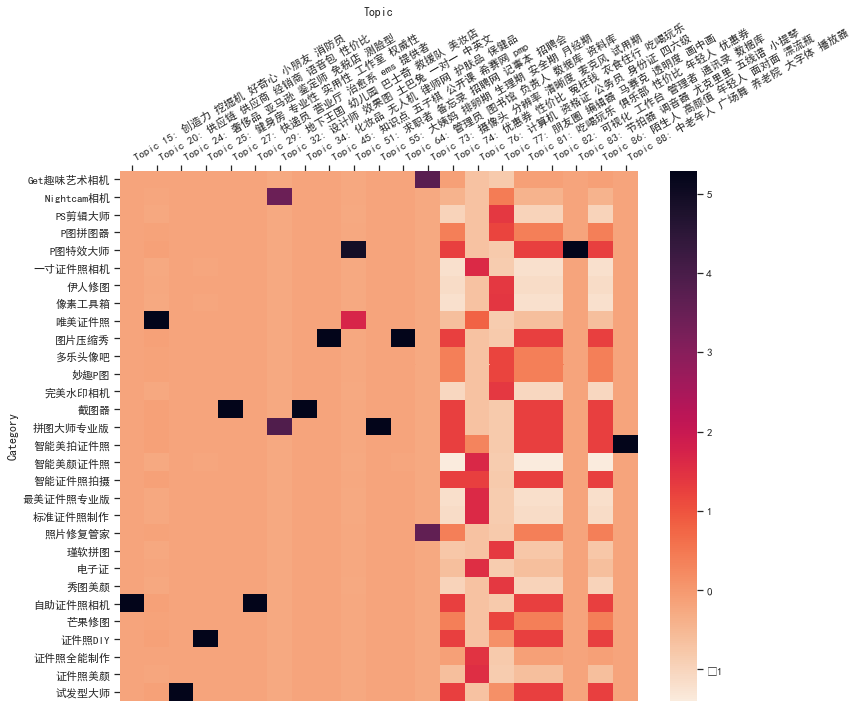

In [83]:
import random
# list_app_name = [t for t in dataset_df['应用名'].tolist()] #所有描述数据list 按顺序

# target_labels = ['轻语','老地方','附近人约会交友','情侣空间','悦缘婚恋','乐事TV','小象嗨TV','梨园','乐播播','来点','三峡手机台']
target_labels = list_names[12290:12310]+list_names[37860:37]
# target_labels = random.sample(list_names, 20) 
plot_categories_by_topics_heatmap_(list_names,
                                      topic_distributions,
                                      topic_keys, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim=(12,10))

如果数据集包含一些时间的分类标签，则创建一组箱线图，每个主题一个图。

In [ ]:

target_labels = ['John Keats', 'Emily Dickinson', 'William Butler Yeats', 'Christina Rossetti']

for _topic_index in range(0, len(topic_keys)):
    
    lmw.plot_categories_by_topic_boxplots(list_names,
                                          topic_distributions,
                                          topic_keys, 
                                          _topic_index,
                                          output_path=output_directory_path + '/boxplot.' + str(_topic_index) + '.pdf',
                                          target_labels=target_labels,
                                          dim=(4,4))

# Plot topics over document time

Splits each training document into N chunks, infers the topics for those chunks (using the pre-trained topic model), and plots mean topic probabilities over document time.

In the example shown, it looks like poems often start with physical descriptions and end with abstract and romantic language.

给定一个数据集，将每个文档分成num_chunks个doc

In [ ]:
divided_documents, document_ids, times = lmw.divide_training_data(training_data,
                                                                  num_chunks=10)

len(divided_documents), len(document_ids), len(times)

In [ ]:
path_to_divided_training_data           = output_directory_path + '/training.split.txt'
path_to_divided_formatted_training_data = output_directory_path + '/mallet.split.training'
path_to_divided_topic_distributions     = output_directory_path + '/mallet.split.topic_distributions.' + str(num_topics)

In [ ]:
#exe/txt文件/txt格式化输出/输入txt的list
lmw.import_data(path_to_mallet,
                path_to_divided_training_data,
                path_to_divided_formatted_training_data,
                divided_documents,
                use_pipe_from=path_to_formatted_training_data)

# **模型使用**
使用已经训练的模型，获取新文档的主题分布

In [38]:
# num_topics = 100  # CHANGE THIS TO YOUR PREFERRED NUMBER OF TOPICS
# output_directory_path = 'huawei_LDA-output-分' + str(num_topics) + '类-重清洗-4-3' # CHANGE THIS TO YOUR OUTPUT DIRECTORY
# path_to_mallet = 'C:/mallet/bin/mallet'  # CHANGE THIS TO YOUR MALLET PATH
# path_to_training_data           = output_directory_path + '/training.txt'
# path_to_formatted_training_data = output_directory_path + '/mallet.training'
# path_to_model                   = output_directory_path + '/mallet.model.' + str(num_topics)
# path_to_topic_keys              = output_directory_path + '/mallet.topic_keys.' + str(num_topics)
# path_to_topic_distributions     = output_directory_path + '/mallet.topic_distributions.' + str(num_topics)
# path_to_word_weights            = output_directory_path + '/mallet.word_weights.' + str(num_topics)
# path_to_diagnostics             = output_directory_path + '/mallet.diagnostics.' + str(num_topics) + '.xml'



path_to_testing_data           = output_directory_path + '/testing.txt'
path_to_formatted_testing_data = output_directory_path + '/mallet.testing'
path_to_tested_topic_distributions     = output_directory_path + '/mallet.test.topic_distributions.' + str(num_topics)

testing_data = ['小学 初中 高中 作文 写作 包含 海量 小学 初中 高中 作文 示例 年级 作文 写法 中考 高考 满分 作文 作文 真 题 作文 预测 专家 建议 指导 年级 单元 同步 写作 素材 开阔 写作 视野 技能 学生 写作 利器']

#exe/txt文件/txt格式化输出/输入txt的list
lmw.import_data(path_to_mallet,
                path_to_testing_data,
                path_to_formatted_testing_data,
                testing_data,
                use_pipe_from=path_to_formatted_training_data)

#path_to_formatted_training_data
#'huawei_LDA-output-分100类/mallet.training'

#'huawei_LDA-output-分100类/mallet.model.100'
#结果集合-16大类下划分小类/L1-topic0/L2-分3小类/mallet.model.3
#path_to_model
lmw.infer_topics(path_to_mallet,
                 path_to_model,
                 path_to_formatted_testing_data, #放新的目标数据集
                 path_to_tested_topic_distributions) #结果输出路径

topic_distributions_test = lmw.load_topic_distributions(path_to_tested_topic_distributions)


'''doc主题向量大到小排序'''
num_max_p_topics =  num_topics #取每个doc最可能的topic个数

indexs_max_p_all_test = [] #存所有doc的主题向量，主题向量=[(主题,概率),()]

for i in range(len(testing_data)): #遍历所有doc
    p_topics = copy.deepcopy(topic_distributions_test[i]) #每个doc的概率list
    indexs_max_p = [] #存1个doc最可能的topic下标

    for j in range(num_max_p_topics): #大到小排列indexs_max_p=[概率从大到小的(topic,p)]
        max_p = max(p_topics)#概率的最大值
        index_max_p = p_topics.index(max_p) #是在第几个topic取该最大值

        # indexs_max_p.append((index_max_p,max_p)) #(主题下标，概率) 
        indexs_max_p.append((index_max_p,round(max_p,4))) #(主题下标，概率) topic加入
        # indexs_max_p.append((index_max_p,round(max_p,4)*100)) #(主题下标，概率) 概率单位%
        p_topics[index_max_p] = -1 #最大值改0

    indexs_max_p_all_test.append(indexs_max_p)
indexs_max_p_all_test

Importing data using pipe...
Complete 0
Inferring topics using pre-trained model...
Complete 0


[[(82, 0.0558),
  (81, 0.0453),
  (74, 0.0433),
  (77, 0.0357),
  (86, 0.0355),
  (11, 0.0268),
  (20, 0.0264),
  (21, 0.0263),
  (14, 0.0249),
  (2, 0.0212),
  (5, 0.0197),
  (69, 0.0193),
  (1, 0.0175),
  (35, 0.0152),
  (41, 0.015),
  (63, 0.0146),
  (43, 0.0144),
  (87, 0.0142),
  (60, 0.0132),
  (51, 0.0129),
  (25, 0.0128),
  (79, 0.0128),
  (46, 0.0127),
  (23, 0.0119),
  (8, 0.0116),
  (73, 0.0115),
  (64, 0.0112),
  (47, 0.0112),
  (72, 0.0112),
  (39, 0.0106),
  (50, 0.0105),
  (10, 0.0102),
  (59, 0.0101),
  (26, 0.0098),
  (9, 0.0098),
  (67, 0.0098),
  (28, 0.0095),
  (71, 0.0094),
  (3, 0.0093),
  (12, 0.0092),
  (78, 0.0091),
  (7, 0.0091),
  (37, 0.0089),
  (22, 0.0084),
  (32, 0.0081),
  (54, 0.0081),
  (38, 0.0081),
  (76, 0.0081),
  (40, 0.0078),
  (13, 0.0077),
  (18, 0.0076),
  (62, 0.0075),
  (15, 0.0074),
  (85, 0.0074),
  (68, 0.0071),
  (29, 0.0068),
  (6, 0.0065),
  (52, 0.0063),
  (4, 0.0063),
  (17, 0.0063),
  (48, 0.0061),
  (56, 0.0056),
  (42, 0.0056),
  

加载每个文档的主题分布

In [ ]:
'''doc主题向量大到小排序'''
num_max_p_topics =  num_topics #取每个doc最可能的topic个数

indexs_max_p_all = [] #存所有doc的主题向量，主题向量=[(主题,概率),()]

for i in range(len(testing_data)): #遍历所有doc
    p_topics = copy.deepcopy(topic_distributions_test[i]) #每个doc的概率list
    indexs_max_p = [] #存1个doc最可能的topic下标

    for j in range(num_max_p_topics): #大到小排列indexs_max_p=[概率从大到小的(topic,p)]
        max_p = max(p_topics)#概率的最大值
        index_max_p = p_topics.index(max_p) #是在第几个topic取该最大值

        # indexs_max_p.append((index_max_p,max_p)) #(主题下标，概率) 
        indexs_max_p.append((index_max_p,round(max_p,4))) #(主题下标，概率) topic加入
        # indexs_max_p.append((index_max_p,round(max_p,4)*100)) #(主题下标，概率) 概率单位%
        p_topics[index_max_p] = -1 #最大值改0

    indexs_max_p_all.append(indexs_max_p)
indexs_max_p_all

创建线图，每个主题一个，显示文档段的平均主题概率

In [ ]:
for _topic_index in range(0, len(topic_keys)):
    lmw.plot_topics_over_time(topic_distributions, topic_keys, times, _topic_index)